In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow, imsave
from tensorflow import keras
import random
import shutil

In [3]:
train_images_path = '/content/drive/MyDrive/Part_B_Assignment_1/Original'
train_masks_path = '/content/drive/MyDrive/Part_B_Assignment_1/Mask'

In [4]:
training_images = os.listdir(train_images_path)

training_masks = os.listdir(train_masks_path)



training_images.sort()
training_masks.sort()

training_images=training_images[:100]
training_masks=training_masks[:100]

print(len(training_images)) #20
print(len(training_masks))

print(training_images[0])
print(training_masks[0])


100
100
002f20ad-2ace-499c-9335-c9080bc3e6b5.png
002f20ad-2ace-499c-9335-c9080bc3e6b5.png


(100, 512, 512, 3)
uint8


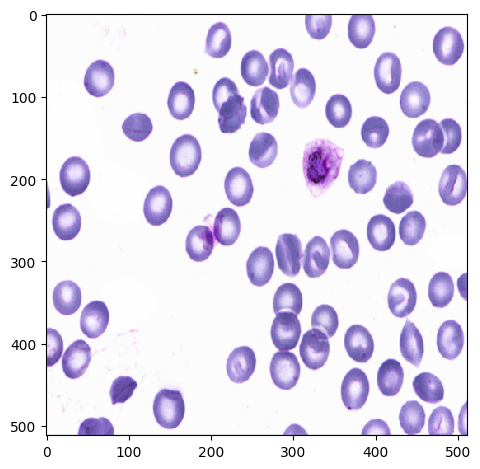

In [5]:
row = 512 #no of rows of resized images
columns = 512 #no of oclumns of resized images

x_train = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)
index = 0
for x in training_images:
    path = os.path.join(train_images_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
   # image.resize((128,128,1))
    x_train[index] = image
    index += 1
print(x_train.shape)
#x_train = x_train / 255
#x_train = x_train.astype('float32')
imshow(x_train[0])
print(x_train.dtype)

uint8


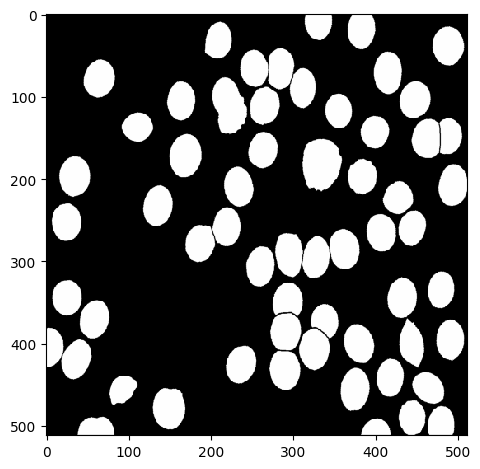

In [6]:
y_train = np.zeros((len(training_masks), row, columns,3), dtype=np.uint8)
#p = os.path.join(train_data_path, training_masks[0])
#i = imread(p)
#k = resize(i, (128, 128))
#imshow(k)

index = 0
for x in training_masks:
    path = os.path.join(train_masks_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y_train[index] = image
    index += 1
y_train.shape
type(y_train)
#y_train = y_train / 255
#y_train = y_train.astype('float32')
print(y_train.dtype)
imshow(y_train[0])

In [7]:
import albumentations as A

# Define the transformation pipeline
transform = A.Compose([
    A.Resize(1200,1600),
    A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% chance
    A.RandomBrightnessContrast(p=0.5),  # Randomly change brightness and contrast with a 50% chance
    A.Blur(blur_limit=7, always_apply=False, p=0.5),  # Apply a blur effect with a 50% chance
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),  # Apply color jitter with a 50% chance
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)  # Add Gaussian noise with a 50% chance
    ])

In [8]:
new_training_images = os.listdir(train_images_path)
new_training_masks = os.listdir(train_masks_path)

new_training_images.sort()
new_training_masks.sort()

new_training_images=new_training_images[:100]
new_training_masks=new_training_masks[:100]

print(len(new_training_images)) #20
print(len(new_training_masks))

aug_x_train = np.zeros((len(new_training_images), 1200, 1600, 3), dtype=np.uint8)  # Array to store transformed images
aug_y_train = np.zeros((len(new_training_masks), 1200, 1600, 3), dtype=np.uint8)  # Array to store transformed masks


100
100


In [9]:
count = 0
for x in range(len(new_training_images)):
    image1 = imread(os.path.join(train_images_path, new_training_images[x]))  # Read image
    mask1 = imread(os.path.join(train_masks_path, new_training_masks[x]))  # Read mask

    # 'transform' applies some augmentation (e.g., resizing, flipping)
    transformed = transform(image=image1, mask=mask1)  # Apply transformations

    # Store the transformed image and mask
    aug_x_train[count] = transformed['image']
    aug_y_train[count] = transformed['mask']
    count += 1

print(aug_x_train.shape)
print(aug_y_train.shape)


(100, 1200, 1600, 3)
(100, 1200, 1600, 3)


In [ ]:
# Directory where augmented images and masks will be saved
pred_dir = '/content/drive/MyDrive/Part_B_Assignment_1/new_preds'

# Create the directory if it doesn't exist
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)

# Save each augmented image and mask with the respective filenames
for x in range(len(aug_x_train)):
    imsave(os.path.join(pred_dir, f'{x:03}_image.png'), aug_x_train[x])  # Save image with leading zeros in filename
    imsave(os.path.join(pred_dir, f'{x:03}_mask.jpg'), aug_y_train[x])   # Save mask with leading zeros in filename

In [10]:
total_train_images = training_images + new_training_images
total_train_masks = training_masks + new_training_masks

In [11]:
# Total number of images
total_x_train = np.zeros((len(training_images) + len(new_training_images), row, columns, 3), dtype=np.uint8)

# Counters
c = 0  # Counter for the total training images
d = 0  # Counter for the augmented training images

# Combine original and augmented images into total_x_train
for x in total_train_images:
    if c < len(training_images):
        # Load and resize original training images
        img = imread(os.path.join(train_images_path, x))
        img = resize(img, (row, columns), mode='constant', preserve_range=True)
        total_x_train[c] = img  # Assign to total_x_train
        c += 1
    else:
        # Load and resize augmented training images
        total_x_train[c] = resize(aug_x_train[d], (row, columns), mode='constant', preserve_range=True)
        c += 1
        d += 1

print(total_x_train.shape)

(200, 512, 512, 3)


In [12]:
row = 512
columns = 512

In [13]:
# Total number of masks
total_y_train = np.zeros((len(training_masks) + len(new_training_masks), row, columns, 3), dtype=np.uint8)

#Counters
e = 0  # Counter for the total training masks
f = 0  # Counter for the augmented training masks

# Combine original and augmented masks into total_y_train
for x in total_train_masks:
    if e < len(training_masks):
        # Load and resize original training masks
        img = imread(os.path.join(train_masks_path, x))
        img = resize(img, (row, columns), mode='constant', preserve_range=True)
        total_y_train[e] = img  # Assign to total_y_train
        e += 1
    else:
        # Load and resize augmented training masks
        total_y_train[e] = resize(aug_y_train[f], (row, columns), mode='constant', preserve_range=True)
        e += 1
        f += 1

print(total_y_train.shape)


(200, 512, 512, 3)


In [14]:
total_y_train = total_y_train.astype('bool')
print(total_y_train.dtype)

bool


(80, 512, 512, 3)
<class 'numpy.ndarray'>
uint8


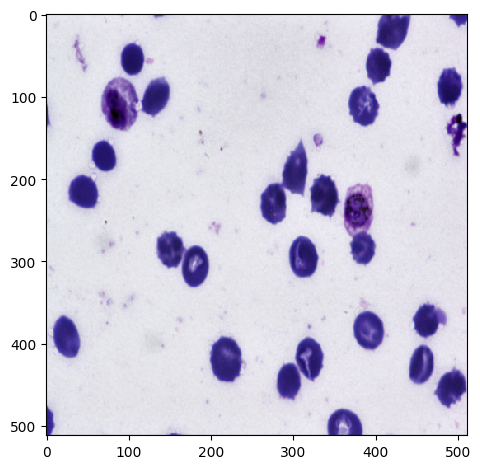

In [15]:
# Set the path to the 'test' folder where test images are stored
test_data_path = '/content/drive/MyDrive/Part_B_Assignment_1/test'

# List all files in the test directory and sort them alphabetically
testing_images = os.listdir(test_data_path)
testing_images.sort()


# Initialize an array to hold 5 resized test images, with shape (row, columns, 3) for RGB images
x_test = np.zeros((len(testing_images), row, columns, 3), dtype=np.uint8)

# Loop through the test images, read and resize them, and store them in x_test
index = 0
for x in testing_images:
    # Read the image from the file
    path = os.path.join(test_data_path, x)
    image = imread(path)

    # Resize the image to the specified dimensions (row, columns)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    # Store the resized image in the x_test array
    x_test[index] = image
    index += 1

# Check the shape and type of x_test after resizing the images
print(x_test.shape)  # Expected Output: (80, row, columns, 3)
print(type(x_test))  # Expected Output: <class 'numpy.ndarray'>
print(x_test.dtype)  # Expected Output: uint8

x_test=x_test[:20]

# Display the first test image
imshow(x_test[0])


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(80, 512, 512, 3)
float32


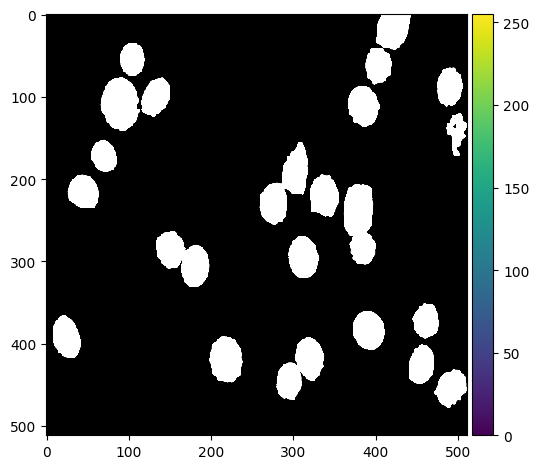

In [16]:
test_mask_path= '/content/drive/MyDrive/Part_B_Assignment_1/test_masks'
testing_masks = os.listdir(test_mask_path)
testing_masks.sort()

# Initialize y_test array to hold 80 test masks, each resized to (512, 512, 3) with float32 type
y_test = np.zeros((len(testing_masks), row, columns, 3), dtype=np.float32)

# Loop through each mask in the testing_masks list
index = 0
for x in testing_masks:
    # Construct the full file path for each mask
    path = os.path.join(test_mask_path, x)

    # Read the mask image from the file
    image = imread(path)

    # Resize the mask image to (row, columns) dimensions
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    # Store the resized mask in the y_test array
    y_test[index] = image
    index += 1

# Check the shape and data type of the y_test array
print(y_test.shape)  # Output: (5, row, columns, 3)
print(y_test.dtype)  # Output: float32

# Display the first mask image
imshow(y_test[0])

# Optional: Normalize y_test if needed
# y_test = y_test / 255
# y_test = y_test.astype('float32')


In [17]:
# Function to calculate Dice Coefficient
def dice_coef(a, b):
    # 'a' is the ground truth, and 'b' is the predicted output
    hi = a  # Assign input 'a' to variable 'hi'
    pred = b  # Assign input 'b' to variable 'pred'

    # Flatten both 'hi' (ground truth) and 'pred' (predictions) into 1D tensors
    hi = K.flatten(hi)
    pred = K.flatten(pred)

    # Calculate the Dice coefficient
    upper_part = 2 * K.sum((hi * pred))  # The numerator: twice the sum of the product of 'hi' and 'pred'
    lower_part = K.sum(hi + pred)  # The denominator: sum of 'hi' and 'pred'

    dice = upper_part / lower_part  # Dice coefficient: ratio of the numerator and denominator
    return dice

# Function to calculate Dice Coefficient Loss
def dice_coef_loss(a, b):
    # Dice loss is 1 minus the Dice coefficient
    loss = 1 - dice_coef(a, b)
    return loss

# Function to calculate Jaccard Index (Intersection over Union - IoU)
def jaccard_index(a, b):
    hi = a  # Assign input 'a' to variable 'hi' (ground truth)
    pred = b  # Assign input 'b' to variable 'pred' (predictions)

    # Flatten both 'hi' and 'pred' into 1D tensors
    hi = K.flatten(hi)
    pred = K.flatten(pred)

    # Calculate the Jaccard Index (IoU)
    numerator = K.sum(hi * pred)  # Intersection: sum of the product of 'hi' and 'pred'
    denominator = K.sum((hi + pred) - (hi * pred))  # Union: sum of 'hi' and 'pred' minus their intersection

    iou = numerator / denominator  # IoU: ratio of intersection to union
    return iou


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


In [19]:
inputs = Input((row, columns, 3))  # Define the input layer with shape (row, columns, 3) for RGB images

# Normalize the input image by dividing by 255 (scaling pixel values between 0 and 1)
s = Lambda(lambda x: x / 255) (inputs)

# First convolution block: Two Conv2D layers with ReLU activation, followed by Dropout
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)  # Max-pooling to reduce spatial dimensions

# Second convolution block
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)  # Max-pooling

# Third convolution block
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)  # Max-pooling

# Fourth convolution block
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)  # Max-pooling

# Fifth convolution block (bottleneck)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Upsampling and concatenation for the first upsampling block
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])  # Skip connection from the corresponding downsampling layer
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

# Second upsampling block
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])  # Skip connection
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

# Third upsampling block
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])  # Skip connection
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

# Fourth upsampling block
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)  # Skip connection
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

# Output layer with sigmoid activation (for 3-channel output)
outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

# Define the model
model = Model(inputs=[inputs], outputs=[outputs])

# Learning rate scheduling (exponential decay)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True
)

# Adam optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Print the shapes of training data (images and masks)
print(total_x_train.shape)  # Shape of the training images
print(total_y_train.shape)  # Shape of the training masks (ground truth)

total_y_train = total_y_train.astype('float32')
# File path to save the trained model
filepath = '/content/drive/MyDrive/Part_B_Assignment_1/model.keras'

# Define an early stopping callback to prevent overfitting
# Stops training when the validation loss doesn't improve for 5 epochs
earlystopper = EarlyStopping(patience=5, verbose=1)

# Define a model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Store the callbacks in a list
callbacks_list = [earlystopper, checkpoint]

# Train the model
history = model.fit(
    total_x_train,           # Training images
    total_y_train,           # Corresponding masks (ground truth)
    validation_split=0.2,    # 20% of data used for validation
    batch_size=8,            # Train with 16 image at a time
    epochs=20,               # Train for a maximum of 20 epochs
    callbacks=callbacks_list  # Use early stopping and checkpoint callbacks
)


(200, 512, 512, 3)
(200, 512, 512, 3)
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - dice_coef: 0.3893 - jaccard_index: 0.2418 - loss: 0.6288 
Epoch 1: val_loss improved from inf to 0.52339, saving model to /content/drive/MyDrive/Part_B_Assignment_1/model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 487s 24s/step - dice_coef: 0.3890 - jaccard_index: 0.2416 - loss: 0.6262 - val_dice_coef: 0.3949 - val_jaccard_index: 0.2461 - val_loss: 0.5234
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - dice_coef: 0.4761 - jaccard_index: 0.3147 - loss: 0.4637 
Epoch 2: val_loss improved from 0.52339 to 0.42470, saving model to /content/drive/MyDrive/Part_B_Assignment_1/model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 515s 25s/step - dice_coef: 0.4783 - jaccard_index: 0.3168 - loss: 0.4622 - val_dice_coef: 0.5117 - val_jaccard_index: 0.3439 - val_loss: 0.4247
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - dice_coef: 0.6900 - jaccard_index: 0.5317 - loss: 0.3240 
Epoch 3: val_loss did not improve from 0.42470
2

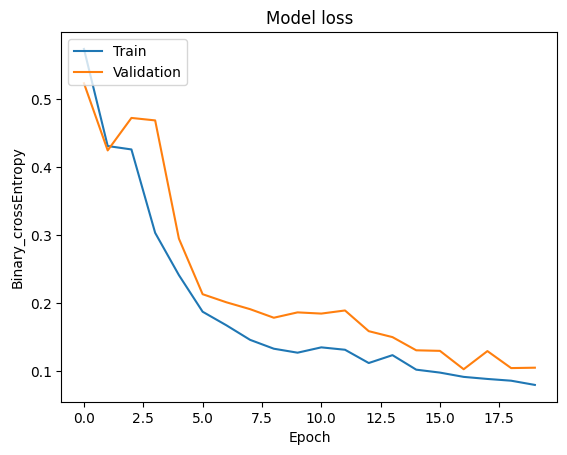

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

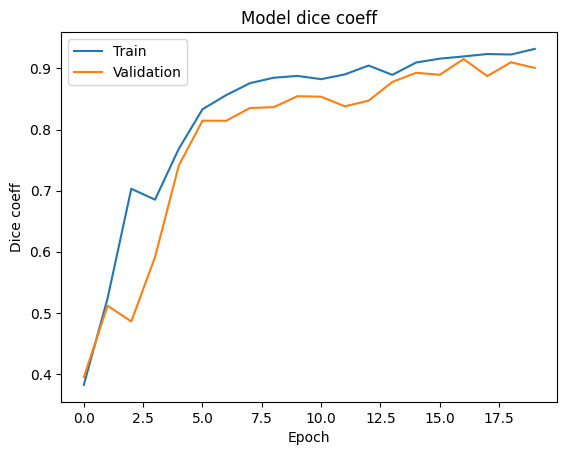

In [22]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

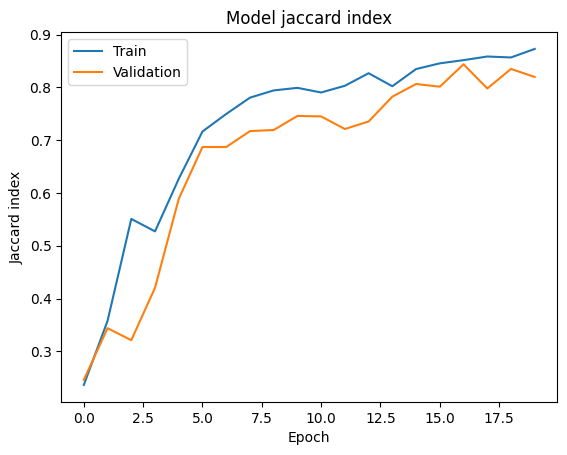

In [23]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
x_test=x_test[:20]

In [24]:
model.load_weights('/content/drive/MyDrive/Part_B_Assignment_1/model.keras')
test_preds = model.predict(x_test)
print(test_preds.shape)
print(type(test_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
(20, 512, 512, 3)
<class 'numpy.ndarray'>


In [26]:
 def dice_coef2(a, b):
#  hi = K.hi
#  hi = hi / 255
#    hi = tf.convert_to_tensor(hi, dtype=None)
#    pred = tf.convert_to_tensor(test_preds, dtype=None)
  hi = a/255
  pred = b
  hi = K.flatten(hi)
  pred = K.flatten(pred)
  upper_part = 2 * K.sum((hi * pred))
  lower_part = K.sum(hi + pred)
  dice = upper_part / lower_part
  return dice

def jaccard_index2(a, b):
  hi = a/255
  pred = b
  hi = K.flatten(hi)
  pred = K.flatten(pred)
  numerator = K.sum(hi * pred)
  denominator = K.sum((hi + pred) - (hi * pred))
  iou = numerator / denominator
  return iou

In [27]:
avg_dice = 0
avg_jaccard = 0
for x in range(len(test_preds)):
  i = y_test[x]
  j = test_preds[x]
  avg_dice = avg_dice + tf.get_static_value(dice_coef2(i,j))
  avg_jaccard = avg_jaccard + tf.get_static_value(jaccard_index2(i,j))

print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Average Test Dice co-efficent:  0.9119188368320466
Average Test Jaccrad Index:  0.8388234049081802


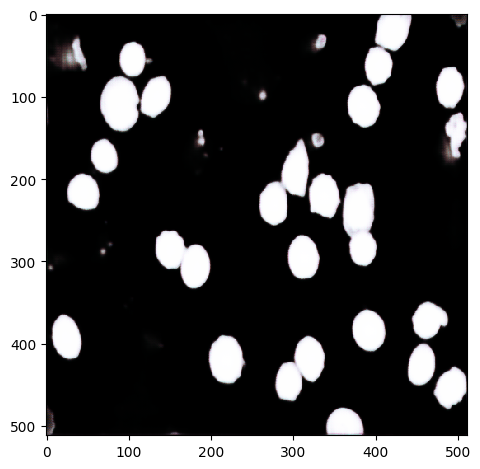

In [37]:
imshow(test_preds[0])

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


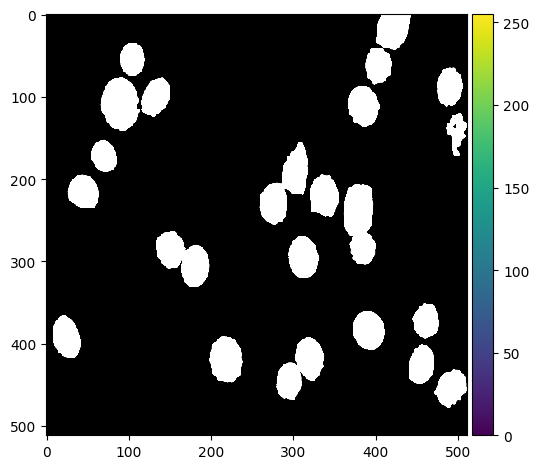

In [38]:
imshow(y_test[0])

In [39]:
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  0.0800824761390686
Lowest validation loss:  0.10313411056995392
Highest training dice coefficient:  0.9318262934684753
Highest validation dice coefficient:  0.9152576327323914
Highest training jaccrad index:  0.8729183077812195
Highest validation jaccard index:  0.8438817858695984
